# import thư viện

In [28]:
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# phân tích dữ liệu

In [29]:
df = pd.read_csv("../data/data-kiem-tra-2.csv")

In [30]:
df

,date,truong_1,truong_2,truong_3,truong_4,truong_5
0,10.05.2013,4,58,3773,299.0,1
1,26.05.2013,4,58,3768,249.0,1
2,19.05.2013,4,58,4036,419.0,1
3,25.05.2013,4,58,12878,149.0,1
4,15.05.2013,4,58,12885,148.0,1
...,...,...,...,...,...,...
550033,07.11.2013,10,37,18474,199.0,1
550034,18.11.2013,10,37,18474,199.0,1
550035,24.11.2013,10,37,18484,199.0,1
550036,11.11.2013,10,37,19751,99.0,1


In [31]:
data = df[["date","truong_3"]]

In [32]:
data

,date,truong_3
0,10.05.2013,3773
1,26.05.2013,3768
2,19.05.2013,4036
3,25.05.2013,12878
4,15.05.2013,12885
...,...,...
550033,07.11.2013,18474
550034,18.11.2013,18474
550035,24.11.2013,18484
550036,11.11.2013,19751


In [33]:

# Chuyển đổi cột 'thời_gian' sang định dạng datetime
data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

# Sắp xếp DataFrame theo cột 'date'
data_sorted = data.sort_values(by='date')

C:\Users\PC\AppData\Local\Temp\ipykernel_5184\2989217094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')


In [34]:
data_sorted = data.sort_values(by='date')

In [35]:
data_sorted

,date,truong_3
10740,2013-05-01,3476
13910,2013-05-01,1904
13907,2013-05-01,1915
28695,2013-05-01,12180
2691,2013-05-01,10928
...,...,...
537467,2013-11-30,20276
537478,2013-11-30,20448
537480,2013-11-30,20506
537326,2013-11-30,2808


In [36]:
# Nhóm các hàng theo 'ngày' và tính tổng 'giá_trị' cho mỗi nhóm
sum_by_day = data_sorted.groupby('date')['truong_3'].sum()

In [37]:
sum_by_day.head()

date
2013-05-01    15073926
2013-05-02    14127032
2013-05-03    13050413
2013-05-04    11324760
2013-05-05    11814357
Name: truong_3, dtype: int64

In [38]:
# Nhóm các hàng theo 'ngày' và tính tổng 'giá_trị' cho mỗi nhóm
sum_by_day = data_sorted.groupby(data_sorted['date'].dt.date)['truong_3'].sum()

# Chuyển đổi Series thành DataFrame
df_sum_by_day = pd.DataFrame({'day': sum_by_day.index, 'truong_3': sum_by_day.values})

df_sum_by_day


,day,truong_3
0,2013-05-01,15073926
1,2013-05-02,14127032
2,2013-05-03,13050413
3,2013-05-04,11324760
4,2013-05-05,11814357
...,...,...
209,2013-11-26,5119426
210,2013-11-27,4821249
211,2013-11-28,5349662
212,2013-11-29,8082867


In [39]:
df_sum_by_day.set_index('day', inplace=True)

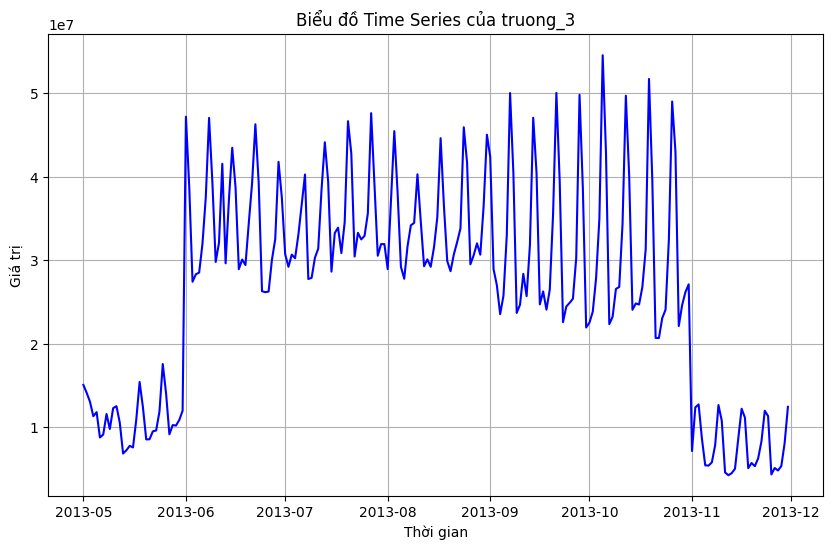

In [40]:

# Vẽ biểu đồ time series
plt.figure(figsize=(10, 6))
plt.plot(df_sum_by_day.index, df_sum_by_day['truong_3'], color='blue')
plt.title('Biểu đồ Time Series của truong_3')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.grid(True)
plt.show()

In [41]:
# Kiểm tra số lượng dữ liệu thiếu trong mỗi cột
df_sum_by_day.isnull().sum()




truong_3    0
dtype: int64

In [42]:
# Sử dụng phương thức describe để xem thông tin thống kê về dữ liệu
df_sum_by_day.describe()



,truong_3
count,2.140000e+02
mean,2.653458e+07
std,1.272667e+07
min,4.254984e+06
25%,1.268014e+07
50%,2.882267e+07
75%,3.490269e+07
max,5.457824e+07


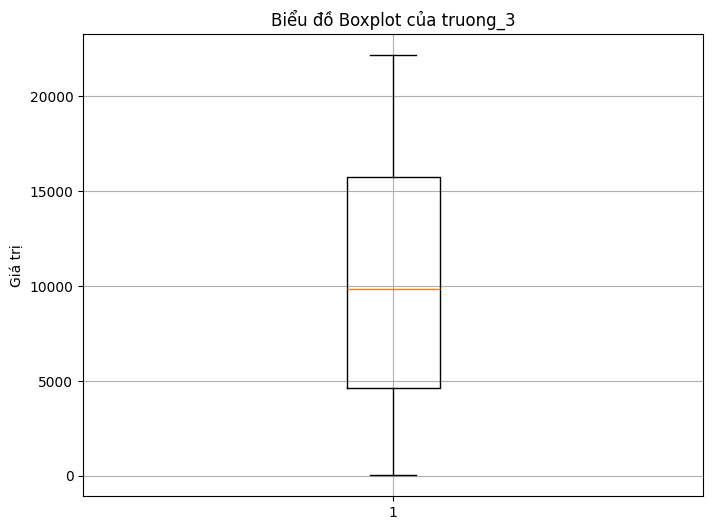

In [43]:
# Vẽ biểu đồ boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(data['truong_3'])
plt.title('Biểu đồ Boxplot của truong_3')
plt.ylabel('Giá trị')
plt.grid(True)
plt.show()

In [44]:
def remove_outliers_iqr(data):
    # Tính IQR cho mỗi cột
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1

    # Xác định giới hạn dưới và giới hạn trên
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Kiểm tra giá trị nhiễu trong DataFrame
    outliers = ((data < lower_bound) | (data > upper_bound)).sum()
    print("Số lượng giá trị nhiễu trong mỗi cột:")
    print(outliers)

    # Loại bỏ các hàng chứa giá trị nhiễu
    cleaned_data = data[~((data < lower_bound) | (data > upper_bound)).any(axis=1)]

    return cleaned_data

cleaned_df = remove_outliers_iqr(df_sum_by_day)

Số lượng giá trị nhiễu trong mỗi cột:
truong_3    0
dtype: int64


In [45]:
cleaned_df

,truong_3
day,
2013-05-01,15073926
2013-05-02,14127032
2013-05-03,13050413
2013-05-04,11324760
2013-05-05,11814357
...,...
2013-11-26,5119426
2013-11-27,4821249
2013-11-28,5349662


# Chạy mô hình SARIMA và ARIMAX

In [46]:
from pmdarima import auto_arima

# Tìm tham số tốt nhất cho mô hình
stepwise_model = auto_arima(cleaned_df, seasonal=True, m=12, trace=True,
                            error_action='ignore', suppress_warnings=True, stepwise=True)

print(stepwise_model.summary())

# Lấy các tham số từ mô hình tự động
p, d, q = stepwise_model.order
P, D, Q, s = stepwise_model.seasonal_order

# Xây dựng mô hình SARIMA với các tham số tìm được
model = SARIMAX(cleaned_df, order=(p, d, q), seasonal_order=(P, D, Q, s))
model_fit = model.fit(disp=False)
# Dự đoán 10 ngày tiếp theo
forecast = model_fit.get_forecast(steps=10)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=7220.287, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7355.125, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7325.769, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=7315.884, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7353.128, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=7229.352, Time=0.39 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=7218.372, Time=0.44 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=7291.994, Time=0.10 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=7220.261, Time=1.05 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=7283.475, Time=0.10 sec
 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=7272.075, Time=0.11 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=7212.847, Time=0.40 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=7310.356, Time=0.12 sec
 ARIMA(3,1,2)(2,0,0)[12]

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

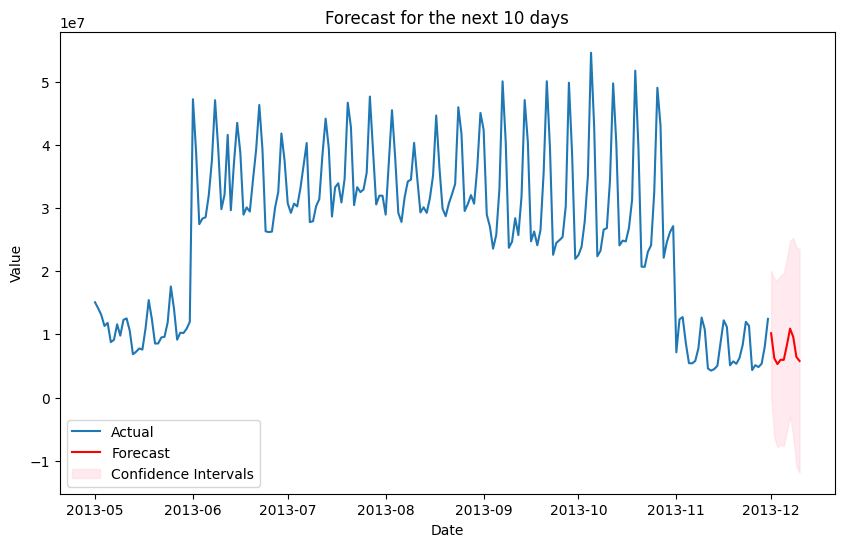

In [47]:
import matplotlib.pyplot as plt

# Lấy giá trị dự đoán và khoảng tin cậy
forecast_values = forecast.predicted_mean#Dòng này lấy giá trị dự đoán từ kết quả của mô hình SARIMA đã được huấn luyện trước đó.
confidence_intervals = forecast.conf_int()

# Tạo mảng ngày dự đoán
forecast_index = pd.date_range(start=cleaned_df.index[-1], periods=10 + 1, freq='D')[1:]

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(cleaned_df.index, cleaned_df.values, label='Actual')
plt.plot(forecast_index, forecast_values, color='red', label='Forecast')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3, label='Confidence Intervals')
plt.title('Forecast for the next 10 days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


In [51]:
from pmdarima.arima import auto_arima

# Tạo dữ liệu exogenous ngẫu nhiên
exog_random = np.random.rand(len(cleaned_df))

# Sử dụng auto_arima để tìm mô hình tốt nhất
model = auto_arima(cleaned_df['truong_3'], exogenous=exog_random, seasonal=True, m=12)

# Dự đoán kết quả cho 10 ngày kế tiếp
forecast = model.predict(n_periods=10, exogenous=np.random.rand(10))
print(forecast)

2013-12-01    1.017319e+07
2013-12-02    6.222316e+06
2013-12-03    5.297326e+06
2013-12-04    5.973403e+06
2013-12-05    5.954857e+06
2013-12-06    8.302565e+06
2013-12-07    1.090335e+07
2013-12-08    9.593446e+06
2013-12-09    6.426744e+06
2013-12-10    5.784306e+06
Freq: D, dtype: float64


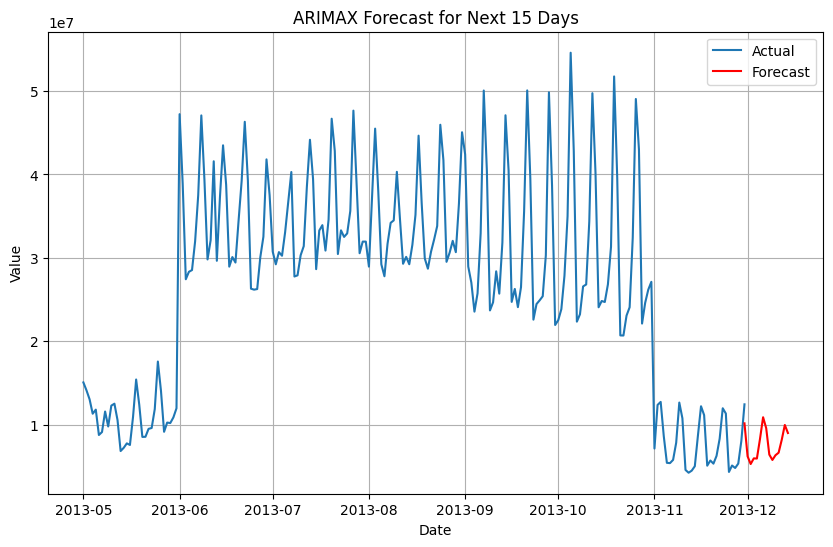

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pmdarima.arima import auto_arima

# Tạo dữ liệu exogenous ngẫu nhiên
exog_random = np.random.rand(len(cleaned_df))

# Sử dụng auto_arima để tìm mô hình tốt nhất
model = auto_arima(cleaned_df['truong_3'], exogenous=exog_random, seasonal=True, m=12)

# Dự đoán kết quả cho 15 ngày kế tiếp
forecast = model.predict(n_periods=15, exogenous=np.random.rand(15))

# Biểu đồ
plt.figure(figsize=(10, 6))

# Dữ liệu thực tế
plt.plot(cleaned_df.index, cleaned_df['truong_3'], label='Actual')

# Dự đoán
plt.plot(pd.date_range(cleaned_df.index[-1], periods=15, freq='D'), forecast, color='red', label='Forecast')

plt.title('ARIMAX Forecast for Next 15 Days')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()